In [7]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc, initialize_COVID19_SEIQRD_spatial_hybrid_vacc 

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
agg='prov'
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
df = sciensano.get_public_spatial_vaccination_data(agg=agg, update=False)
df = df['INCIDENCE']

## Part 1: N_vacc function

In [9]:
from covid19model.models.time_dependant_parameter_fncs import make_N_vacc_function

In [10]:
# Slice dataset to a moment before the booster campaign
start_booster = '2022-05-02'#'2021-10-04'
df_incidences = df.loc[slice('2020-12-28',start_booster), slice(None), slice(None)]
# Initialize TDPF
output = make_N_vacc_function(agg=agg, df_incidences=df_incidences, hypothetical_function=True)

KeyError: Interval(0, 12, closed='left')

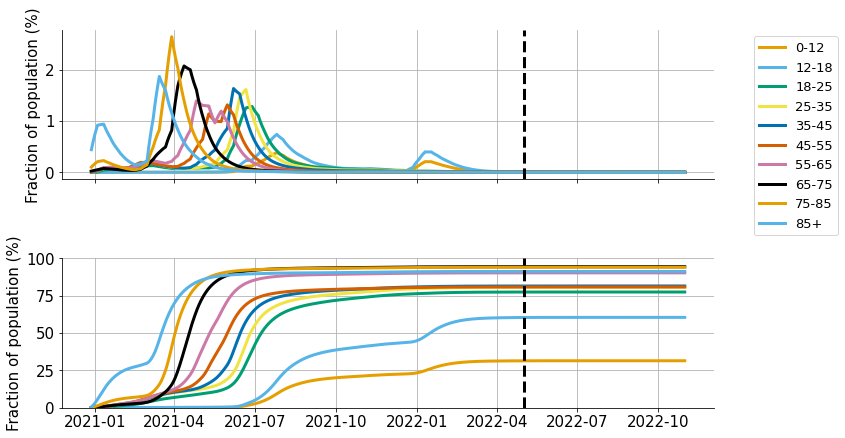

In [5]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = output.df
dose='A'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
#plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()

### Upsample to weekly frequency

In [6]:
groupers=[]
for index_name in df.index.names:
    if index_name != 'date':
        groupers += [pd.Grouper(level=index_name)]
    else:
        groupers += [pd.Grouper(level='date', freq='W-MON')]
df_incidences = df.groupby(groupers).sum()

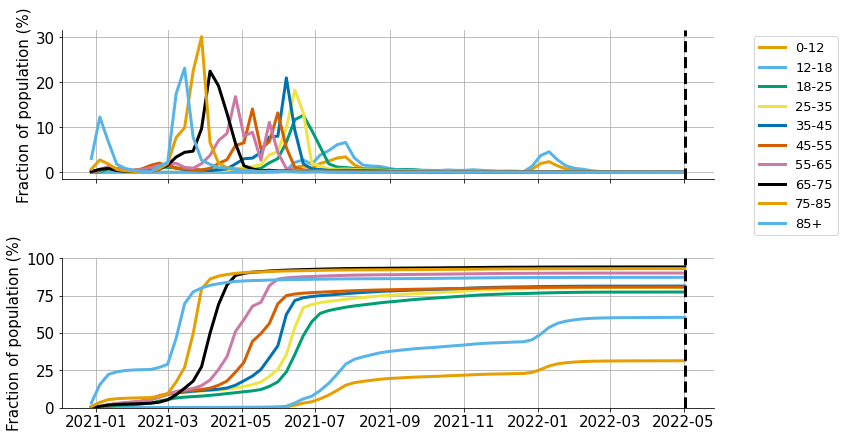

In [7]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = df_incidences
dose='A'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
#plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()

## Part 2: rescaling function for waning

In [11]:
from covid19model.models.time_dependant_parameter_fncs import make_vaccination_rescaling_function
from covid19model.data.model_parameters import get_COVID19_SEIQRD_VOC_parameters

In [12]:
df = df_incidences
update=False
from covid19model.models.time_dependant_parameter_fncs import make_vaccination_efficacy_function
# Load currently saved VOC parameters
VOC_params, vaccine_params = get_COVID19_SEIQRD_VOC_parameters()
function = make_vaccination_efficacy_function(update=update, agg=agg, df_incidences=df, vaccine_params=vaccine_params,
                                              VOCs=['WT', 'abc', 'delta'], age_classes=age_classes)

In [13]:
df_efficacies=function.df_efficacies
print(df_efficacies.head(5))

                                          e_s   e_i       e_h
date       NIS   age     dose    VOC                         
2020-12-28 10000 [0, 12) none    WT     0.000  0.00  0.000000
                                 abc    0.000  0.00  0.000000
                                 delta  0.000  0.00  0.000000
                         partial WT     0.435  0.31  0.061947
                                 abc    0.435  0.31  0.061947


In [14]:
t = pd.Timestamp('2021-01-08')
out = function.e_s(t, {}, {})
print(out[0,-1,:,:])

[[1.         1.         1.        ]
 [0.57024224 0.57024224 0.60976019]
 [0.13       0.13       0.21      ]
 [0.13       0.13       0.2       ]]


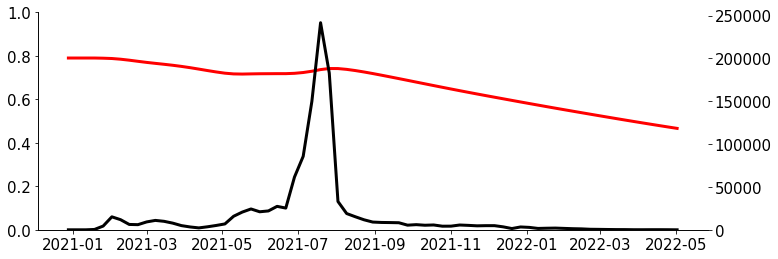

In [12]:
age_class = age_classes[3]
VOC='delta'

fig,ax=plt.subplots(figsize=(12,4))
ax.plot(df_efficacies.loc[(slice(None), age_class, 'full', VOC)]['e_s'], color='red')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(df.loc[slice(None),age_class,'B'], color='black')
ax2.set_ylim([0,None])

#ax.plot(df_efficacies.loc[(slice(None), age_class, 'full', VOC)]['e_i'], color='orange')
#ax.plot(df_efficacies.loc[(slice(None), age_class, 'boosted', VOC)]['e_i'], color='green')
ax.grid(False)
ax2.grid(False)
plt.show()
plt.close()

## Part 3: Running the national model with both TDPFs

In [92]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [93]:
end_sim = '2022-01-01'
out = model.sim(end_sim,start_date=start_date)

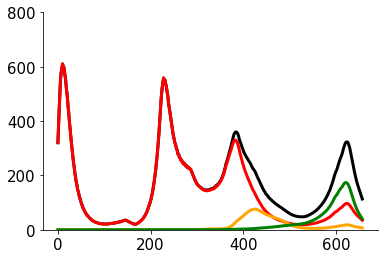

In [94]:
fig,ax=plt.subplots()
ax.plot(out['H_in'].sum(dim='Nc').sum(dim='doses'), color='black')
ax.plot(out['H_in'].sum(dim='Nc').sel(doses='none'), color='red')
ax.plot(out['H_in'].sum(dim='Nc').sel(doses='partial'), color='orange')
ax.plot(out['H_in'].sum(dim='Nc').sel(doses='full'), color='green')
ax.set_ylim([0,800])
ax.grid(False)
plt.show()
plt.close()

## Part 4: Running the spatial model with both TDPFs

In [95]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [ ]:
end_sim = '2022-01-01'
out = model.sim(end_sim,start_date=start_date)

0.0
0.01769862881570412
0.026490644711099465
0.0397359670666492
0.05298128942219893
0.3178877365331936
0.4503409600886909
0.5827941836441882
1.3552137878718944
1.741423589985747
2.1276333920996002
2.8361425176127852
3.1903970803693777
3.5446516431259703
4.376010012351305
4.791689196963973
5.20736838157664
6.047531929143686
6.467613702927208
6.887695476710731
7.648260471298586
8.028542968592513
8.40882546588644
9.28067119485353
9.716594059337076
10.15251692382062
11.008324352240004
11.436228066449697
11.864131780659388
12.670110879779836
13.073100429340059
13.476089978900283
14.2939283739506
14.702847571475758
15.111766769000916
15.877661318200847
16.260608592800814
16.643555867400778
17.36876448059384
17.731368787190366
18.093973093786897
18.912555771097836
19.321847109753303
19.73113844840877
20.554587350857815
20.966311802082338
21.37803625330686
22.252387886781523
22.689563703518857
23.126739520256187
23.998778517681323
24.434798016393895
24.870817515106463
25.67197204432819
26.0725

182.5003451617997
182.96081802398697
183.42129088617426
184.29174408412544
184.72697068310103
185.16219728207662
184.1538790271352
184.52017309761564
184.8864671680961
185.619055309057
185.98534937953747
186.35164345001792
187.29110569267937
187.76083681401008
188.2305679353408
189.16350090625667
189.62996739171464
190.0964338771726
188.94292780786702
189.2991077441301
189.65528768039323
190.36764755291944
190.72382748918255
191.08000742544567
191.9770988778539
192.42564460405802
192.87419033026214
193.9384662556313
194.47060421831588
195.00274218100049
193.7198057471681
194.14261345562107
194.56542116407405
195.41103658098
195.833844289433
196.25665199788597
197.05036767960627
197.44722552046642
197.84408336132657
196.8986187532699
197.21960213096187
197.54058550865383
198.18255226403778
198.50353564172974
198.8245190194217
199.81833977443307
200.31525015193876
200.81216052944444
201.92652145225532
202.48370191366072
203.04088237506616
201.7759863183283
202.2578992127702
202.739812107

336.76151140910684
337.1396186118022
337.5177258144975
338.5670944325886
339.09177874163413
339.61646305067967
338.286690149524
338.67117231703725
339.0556544845505
339.8246188195769
340.2091009870902
340.59358315460344
341.5336407222554
342.00366950608145
342.4736982899074
343.5460324529133
344.0821995344163
344.6183666159193
343.37553933020445
343.826459850353
344.27738037050153
345.14892853075276
345.58470261087837
346.020476691004
344.97353029004717
345.32160524982004
345.66968020959285
346.36583012913854
346.71390508891136
347.0619800486842
348.08025425929065
348.58939136459395
349.0985284698972
350.10682083367556
350.61096701556477
351.115113197454
349.7979474128123
350.14765688426985
350.49736635572737
351.19678529864245
351.5464947701
351.89620424155754
352.7998719473677
353.2517058002728
353.7035396531779
352.400914957835
352.65327031597377
352.9056256741125
353.41033639039
353.66269174852874
353.9150471066675
354.5350444986259
354.84504319460507
355.15504189058424
354.4206716

496.33496929950144
495.143471072902
495.51500133730156
495.88653160170105
496.6295921305001
497.00112239489965
497.37265265929915
498.1009237940327
498.4650593613995
498.82919492876624
497.9299713966733
498.20863076536034
498.48729013404744
499.0446088714216
499.32326824010863
499.60192760879573
500.70999866645786
501.26403419528896
501.81806972412005
503.0852902201397
503.7189004681495
504.3525107161594
502.4864364209908
502.82061976942623
503.1548031178616
503.8231698147324
504.1573531631678
504.49153651160316
505.2135975185756
505.5746280220619
505.93565852554815
506.6320285937421
506.9802136278391
507.32839866193603
508.14496620301804
508.5532499735591
508.9615337441001
509.9195226627511
510.39851712207656
510.8775115814021
511.8689533283683
512.3646742018515
512.8603950753346
511.5883913174108
511.9438311854152
512.2992710534196
512.9936078061238
513.3407761824759
513.687944558828
514.4972067521874
514.901837848867
515.3064689455467
516.2663986744901
516.7463635389618
517.22632840

644.332536788593
643.3792766687199
643.7593695926171
644.1394625165143
644.8996483643087
645.279741288206
645.6598342121032
646.650129698301
647.1452774413999
647.6404251844989
646.4163627243786
646.7946269805162
647.1728912366539
647.9294197489291
648.3076840050669
648.6859482612045
649.6340779662713
650.1081428188047
650.5822076713381
651.5803744612808
652.0794578562522
652.5785412512236
651.1402255639277
651.4192345102225
651.6982434565173
652.2562613491068
652.5352702954017
652.8142792416965
653.4079045167023
653.7047171542052
654.0015297917082
655.0484491617642
655.5719088467923


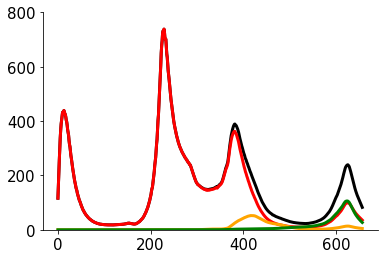

In [91]:
fig,ax=plt.subplots()
ax.plot(out['H_in'].sum(dim='place').sum(dim='Nc').sum(dim='doses'), color='black')
ax.plot(out['H_in'].sum(dim='place').sum(dim='Nc').sel(doses='none'), color='red')
ax.plot(out['H_in'].sum(dim='place').sum(dim='Nc').sel(doses='partial'), color='orange')
ax.plot(out['H_in'].sum(dim='place').sum(dim='Nc').sel(doses='full'), color='green')
ax.grid(False)
ax.set_ylim([0,800])
plt.show()
plt.close()